In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# jupyter lab --NotebookApp.iopub_data_rate_limit=1.0e20
import warnings
warnings.filterwarnings('ignore')

## Load data

In [179]:
from pathlib import Path

import matplotlib.pylab as plt
import numpy as np
import pytorch_lightning as pl
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchinfo import summary
from pytorch_lightning.loggers import TensorBoardLogger

from lstm_model_behavior import RecurrentAutoencoder
from lin_ae_model_behavior import LinearAutoencoder

plt.rcParams['figure.dpi'] = 100

In [38]:
PATH_ROOT = Path('/Volumes/GoogleDrive/My Drive/NMA-22/naturalistic_arm_movements_ecog')
PATH_DATA = PATH_ROOT / 'data' / 'behavior_data'
SEED = 42

DTYPE = torch.float
DEVICE = torch.device("mps")

In [71]:
# dataset_full = np.load(PATH_DATA / "reaches.npy")
dataset_full = np.load(PATH_DATA / "reaches_scales.npy")

k_mean_labels = np.load(PATH_DATA / "k_mean_labels.npy")
dataset_full.shape

(5984, 2, 150)

## Prepare data

In [180]:
dataset = np.swapaxes(dataset_full, 2, 1)
# X_train, X_test = train_test_split(dataset[k_mean_labels == 2], test_size=0.04, random_state=SEED)
# X_train, X_test = train_test_split(dataset, test_size=0.04, random_state=SEED)
# k_mean_mask = k_mean_labels == 0
# k_mean_mask = (k_mean_labels == 2) | (k_mean_labels == 8) | (k_mean_labels == 6) | (k_mean_labels == 0) 
# k_mean_mask = k_mean_labels > 0

n_points = 50
X_train, X_test = train_test_split(dataset[:, :75, :], test_size=0.04, random_state=SEED)

X_train, X_val = train_test_split(X_train, test_size=0.33, random_state=SEED)

X_train = torch.tensor(X_train, device=DEVICE, dtype=DTYPE)
X_test = torch.tensor(X_test, device=DEVICE, dtype=DTYPE)
X_val = torch.tensor(X_val, device=DEVICE, dtype=DTYPE)

# train_data = TensorDataset(X_train)
# test_data = TensorDataset(X_test)
X_train.shape

torch.Size([3848, 75, 2])

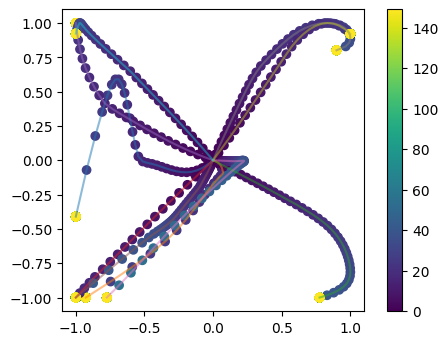

In [181]:
def plot_reaches_(coords):
    x = coords[0]
    y = coords[1]
    plt.plot(x, y, '-', alpha = 0.5)
    plt.scatter(x, y, c = np.arange(len(x)))



for event in range(10):
    plot_reaches_(dataset_full[event, :, :])
    plt.gca().set_aspect('equal')

plt.colorbar()
plt.show()

## Load model

In [147]:
rae_test = RecurrentAutoencoder(75, 2, 16, 3)
summary(rae_test, (1, 75, 2),
        col_names=["input_size", "output_size", "num_params",
                  ]) # "kernel_size", "mult_adds", "trainable"]

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
RecurrentAutoencoder                     [1, 75, 2]                [1, 75, 2]                --
├─Encoder: 1-1                           [1, 75, 2]                [1, 16]                   --
│    └─LSTM: 2-1                         [1, 75, 2]                [1, 75, 32]               21,504
│    └─LSTM: 2-2                         [1, 75, 32]               [1, 75, 16]               3,200
├─Decoder: 1-2                           [1, 16]                   [1, 75, 2]                --
│    └─LSTM: 2-3                         [1, 75, 16]               [1, 75, 16]               2,176
│    └─LSTM: 2-4                         [1, 75, 16]               [1, 75, 32]               23,296
│    └─Linear: 2-5                       [1, 75, 32]               [1, 75, 2]                66
├─MSELoss: 1-3                           --                        --                        --
Total params: 50,242


## Train model

In [148]:
#@title Init model
pl.seed_everything(42)
_, n_times, n_features = X_train.shape
K = 16
n_layers = 3

# Initialize model and Trainer
rae = RecurrentAutoencoder(n_times, n_features, K, n_layers)
rae.lr = 1e-2

pl.utilities.model_summary.summarize(rae, max_depth=-1)

Global seed set to 42


  | Name                 | Type    | Params
-------------------------------------------------
0 | encoder              | Encoder | 24.7 K
1 | encoder.rnn1         | LSTM    | 21.5 K
2 | encoder.rnn2         | LSTM    | 3.2 K 
3 | decoder              | Decoder | 25.5 K
4 | decoder.rnn1         | LSTM    | 2.2 K 
5 | decoder.rnn2         | LSTM    | 23.3 K
6 | decoder.output_layer | Linear  | 66    
7 | custom_loss          | MSELoss | 0     
-------------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)

In [ ]:
n_epochs = 20
batch_size = 250

logger = TensorBoardLogger(
    "tb_logs",
    name=f"K_{K}_lr_{rae.lr}_bs_{batch_size}_nl_{n_layers}_grad_acc_T_LR_sch_T")


trainer = pl.Trainer(
    max_epochs=n_epochs, 
    accelerator='mps',
    logger=logger,
    accumulate_grad_batches={0: 8, 4: 4, 8: 1}
    )

# Perform training
trainer.fit(rae,
            DataLoader(
                X_train,
                batch_size=batch_size,
                shuffle=True),
            DataLoader(
                X_val,
                batch_size=batch_size,
                shuffle=False),
            )

# Perform evaluation
trainer.test(rae, DataLoader(
    X_test,  # mock_data,
    shuffle=False))

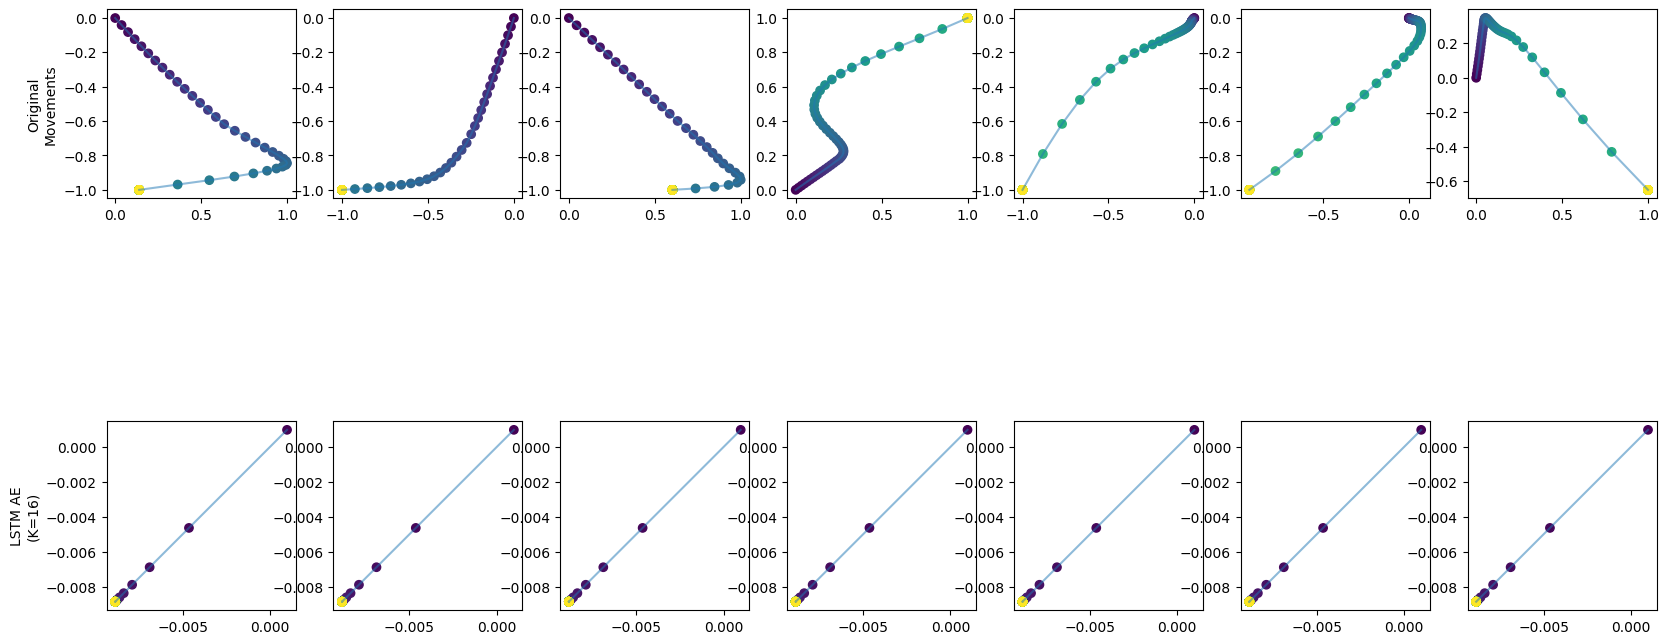

In [150]:
n_plot = 7
plt.figure(figsize=(20, 10))
# dataset_all = X_train.to('cpu')
dataset_all = X_train.to('cpu') # [k_mean_labels == 8]

def plot_reaches_(x, y):
    plt.plot(x, y, '-', alpha = 0.5)
    plt.scatter(x, y, c=np.arange(75))

for i in range(n_plot):
    idx = torch.randint(len(dataset_all), size=())
    data_ = dataset_all[idx]
    
    plt.subplot(2, n_plot, i+1)
    plot_reaches_(data_[:, 0], data_[:, 1])
    plt.gca().set_aspect('equal')
    if i == 0:
        plt.ylabel('Original\nMovements')

    with torch.no_grad():
      # Get reconstructed movements from autoencoder
      rae_recon = rae(data_.unsqueeze(0).to('cpu').float())[0]



    plt.subplot(2, n_plot, i + 1 + n_plot)
    plot_reaches_(rae_recon[:, 0], rae_recon[:, 0])
    plt.gca().set_aspect('equal')
    if i == 0:
        plt.ylabel(f'LSTM AE\n(K={K})')

plt.show()

## Explore embedding space

SEE: https://www.kaggle.com/code/rohitgr/autoencoders-tsne/notebook

In [24]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
import ipywidgets

In [212]:
# download more params
PATH_ROI = PATH_ROOT / "data" / "Naturalistic reach ECoG tfrs ROI"
data = pd.read_csv(PATH_ROI / "power-roi-all-patients-metadata.csv", index_col=0)
data.head()

,day,time,event_timestamp,mvmt,vid_name,event_frame_idx,false_pos,patient_id,I_over_C_ratio,r_wrist_x,...,l_wrist_y,audio_ratio,reach_duration,reach_r,reach_a,onset_velocity,other_reach_overlap,bimanual,other_lead_lag,patient_index
0,3,3520224,3520224,r_wrist,a0f66459_5_0500.avi,2206,0,a0f66459,0.029668,"[292.4933419228, 292.4933419228, 292.493341922...",...,"[211.6673732102, 211.6988453865, 211.667373210...",0.173995,29,56.068108,-152.360333,3.133708,0,0,NaN,0
1,3,3584342,3584342,r_wrist,a0f66459_5_0501.avi,536,0,a0f66459,0.005848,"[288.1831774712, 288.1836948395, 288.183694839...",...,"[208.3187561035, 208.3187561035, 208.318756103...",0.185332,29,120.020850,-103.292387,5.215469,0,0,NaN,0
2,3,28768352,28768352,r_wrist,a0f66459_5_0711.avi,73,0,a0f66459,0.039133,"[277.4298783541, 277.6194574833, 277.619457483...",...,"[221.6612606049, 221.6737040281, 221.794342160...",0.365911,41,37.482779,147.428994,3.061077,0,0,NaN,0
3,3,28853918,28853918,r_wrist,a0f66459_5_0711.avi,2640,0,a0f66459,0.030491,"[279.3920893669, 279.3920893669, 279.392089366...",...,"[222.3323924541, 222.3482117653, 222.35734725,...",0.501548,19,35.601992,-122.635080,2.163772,0,0,NaN,0
4,3,29639049,29639049,r_wrist,a0f66459_6_0000.avi,674,0,a0f66459,0.454378,"[252.2575044632, 252.2575044632, 252.257504463...",...,"[228.3691136539, 228.3421618044, 228.038380678...",0.238979,24,94.181709,-56.404814,5.021071,19,1,3.0,0


(array([49., 25., 22., 20., 17., 17.,  6.,  6.,  1.,  5.]),
 array([ 76. ,  80.2,  84.4,  88.6,  92.8,  97. , 101.2, 105.4, 109.6,
        113.8, 118. ]),
 <BarContainer object of 10 artists>)

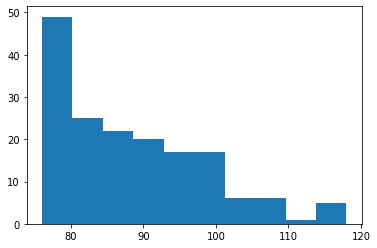

In [34]:
plt.hist(data.reach_duration[data.reach_duration > 75])

In [32]:
def plot_reaches_(x, y, duration=0):
    plt.plot(x, y, '-', alpha = 0.5)
    plt.scatter(x, y, c=np.arange(75))
    if duration != 0:
        plt.scatter(x[duration], y[duration], c = "r")
    plt.xlim(-0.15, 0.15) 
    plt.ylim(-0.15, 0.15) 

def plot_reaches(event):
    x = dataset[event, :, 0]
    y = dataset[event, :, 1]

    plot_reaches_(x,  y, data.loc[event].reach_duration)
    plt.colorbar()
    plt.show()

ipywidgets.interact(plot_reaches, event=ipywidgets.IntSlider(
    min=0, max=dataset.shape[0]-1, step=1, value=10))

interactive(children=(IntSlider(value=10, description='event', max=5983), Output()), _dom_classes=('widget-int…

<function __main__.plot_reaches(event)>

In [510]:
with torch.no_grad():
    z_x_train = rae.encoder(torch.tensor(dataset[k_mean_mask], device='cpu', dtype=DTYPE))
    z_x_train = z_x_train.detach().numpy()

In [511]:
dataset[k_mean_mask].shape

(1055, 75, 2)

In [512]:
X_TSNE = TSNE(n_components=2, random_state=SEED).fit_transform(z_x_train)
X_PCA = PCA(n_components=2, random_state=SEED).fit_transform(z_x_train)

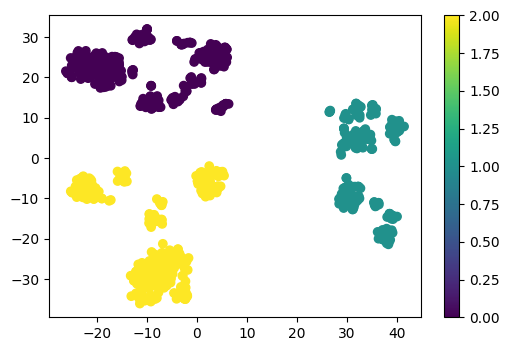

In [520]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
Y_TSNE = kmeans.fit_predict(X_TSNE)
plt.scatter(X_TSNE[:, 0], X_TSNE[:, 1], c = Y_TSNE)
plt.colorbar()

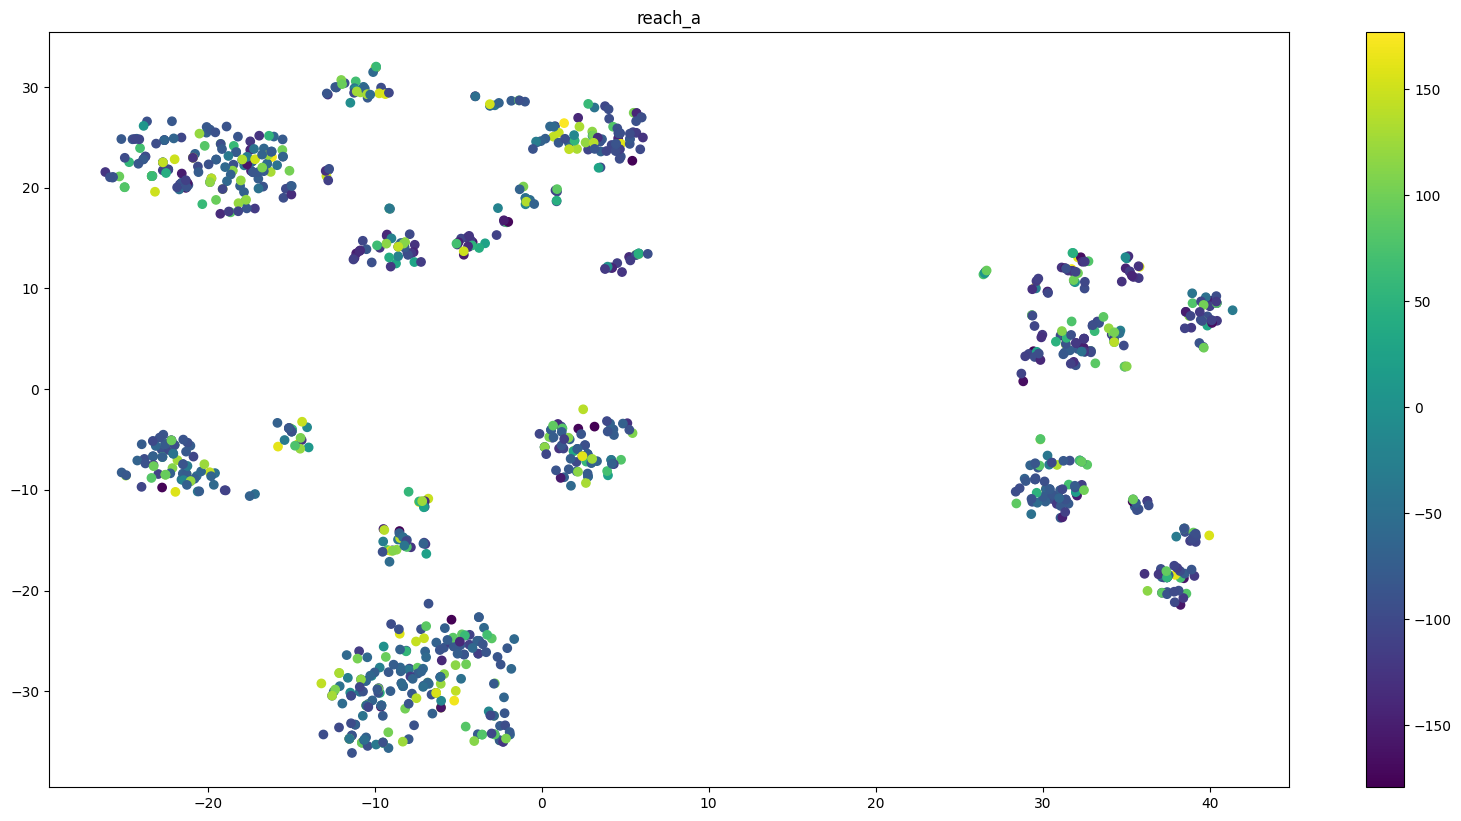

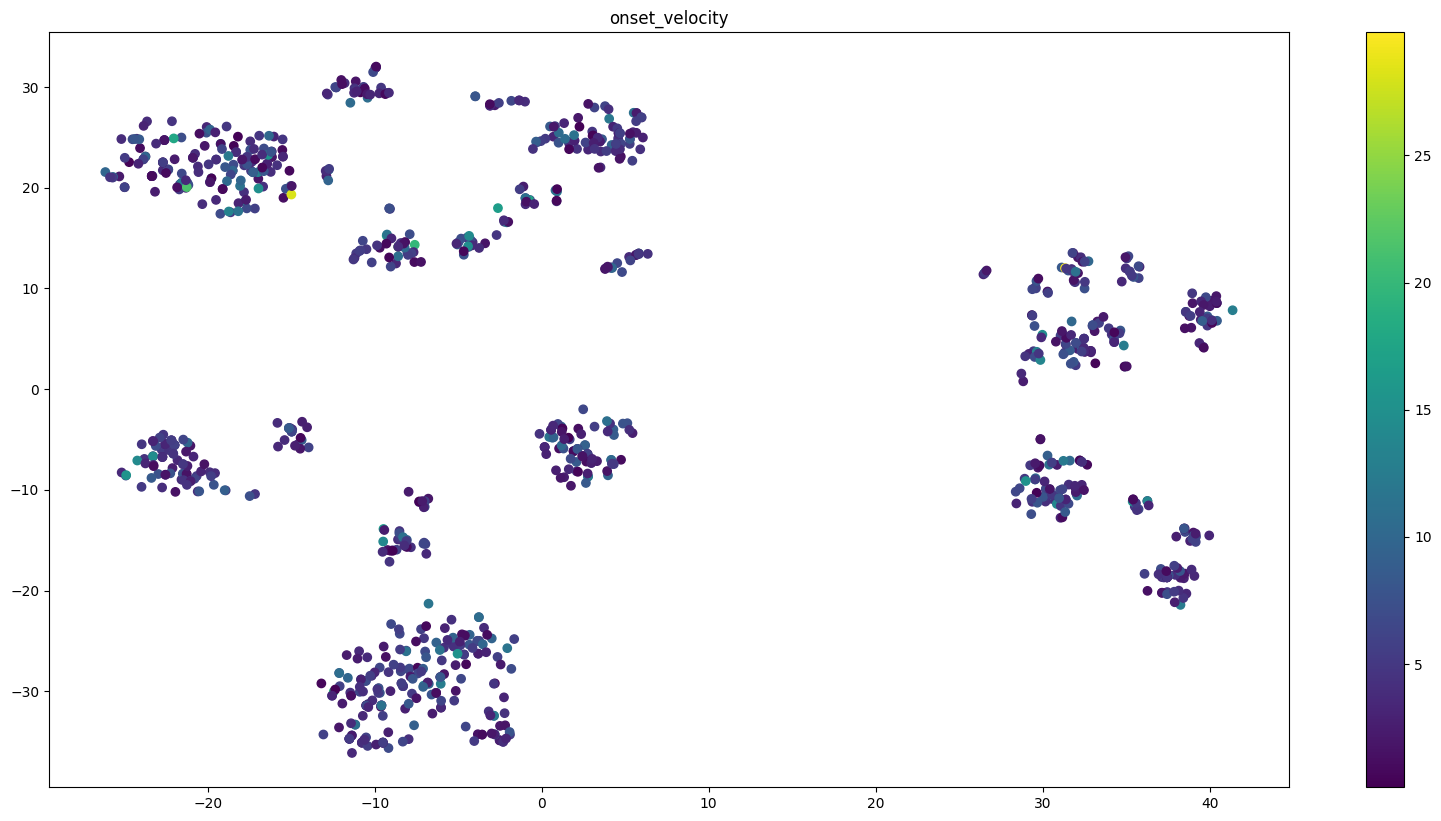

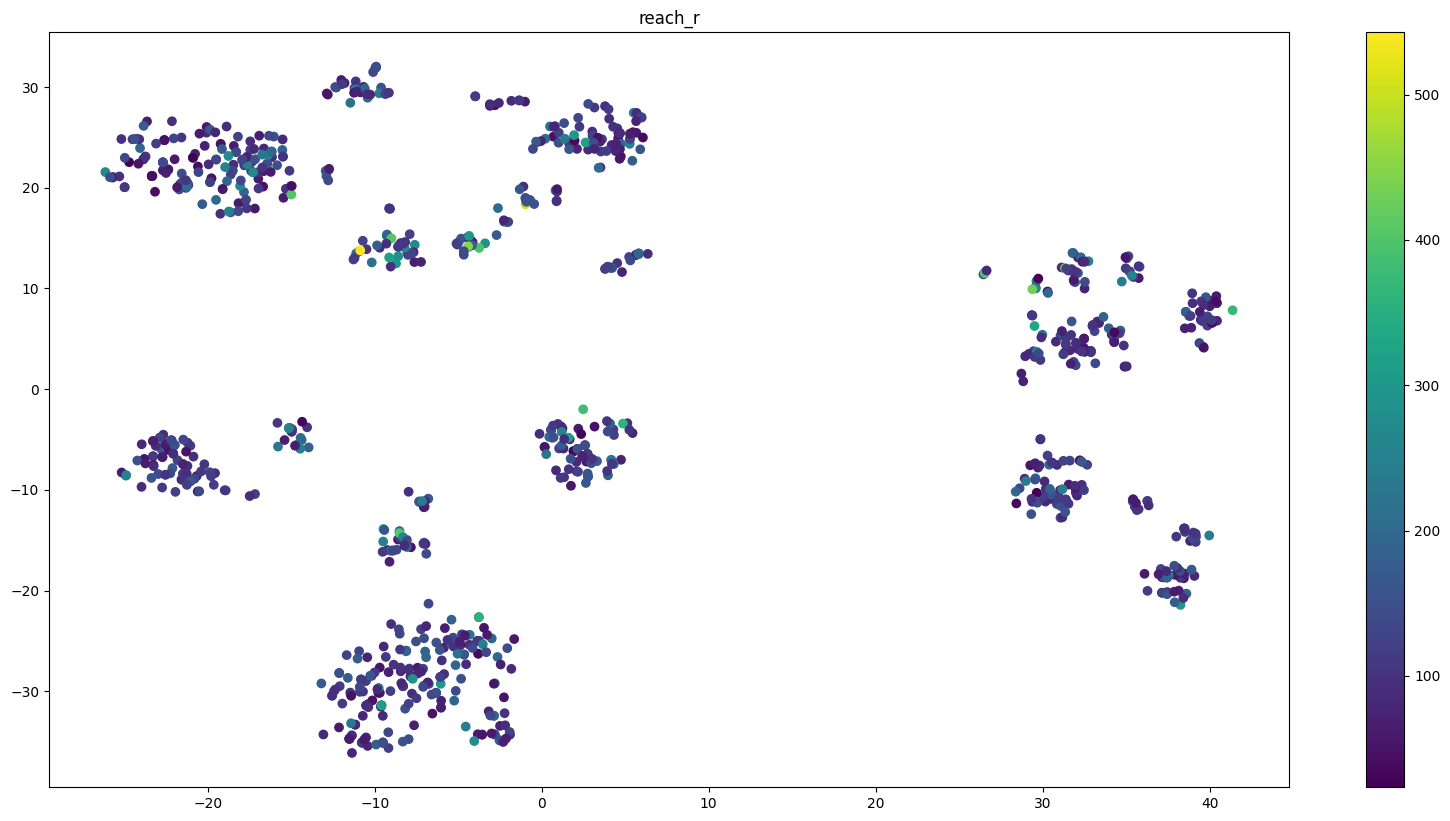

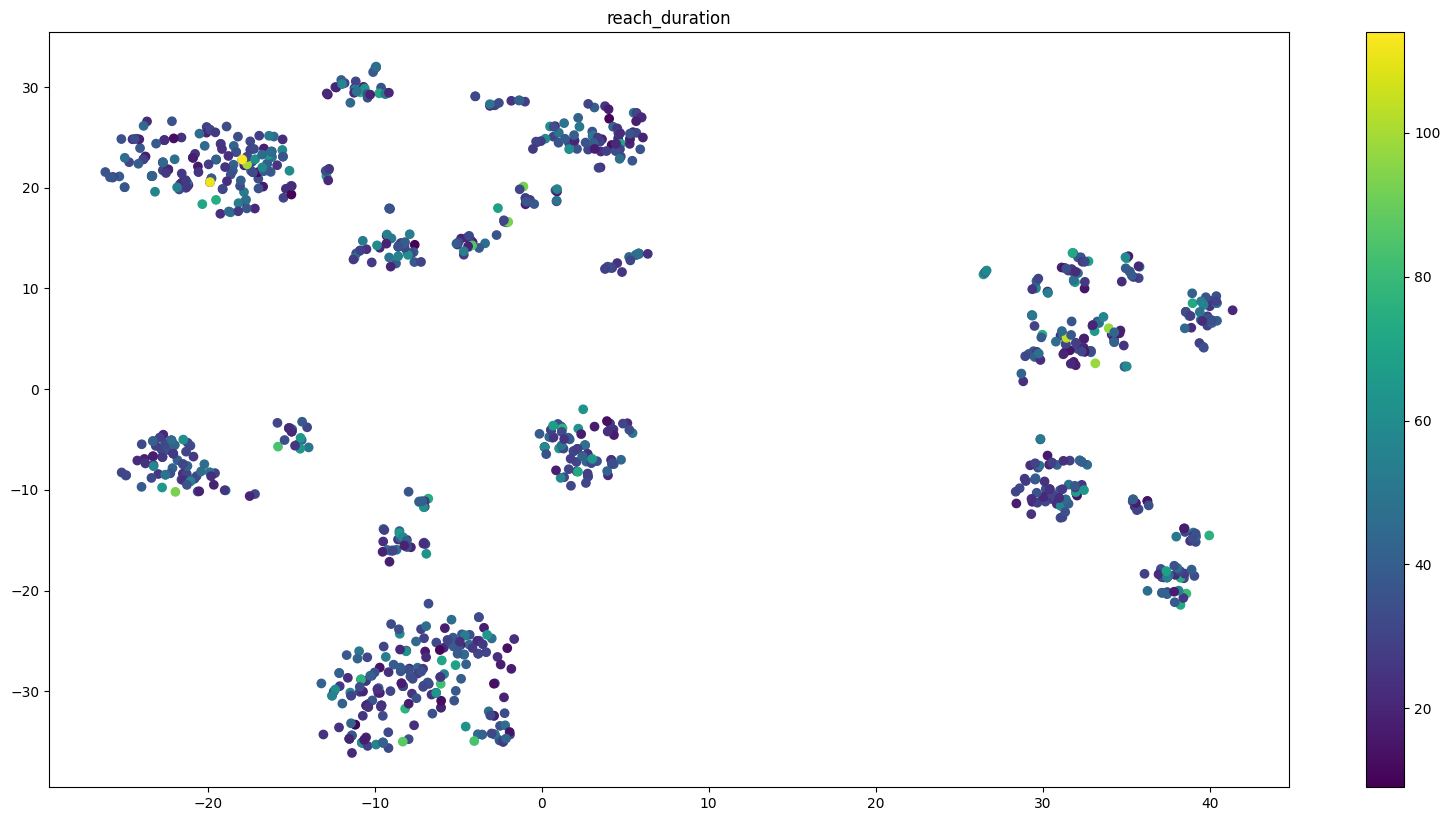

In [517]:
for par in ['reach_a', 'onset_velocity', 'reach_r', 'reach_duration']:
    plt.figure(figsize=(20, 10))
    plt.scatter(X_TSNE[:, 0], X_TSNE[:, 1], c = data.loc[k_mean_mask, par])
    plt.title(par)
    plt.colorbar()
    plt.show()

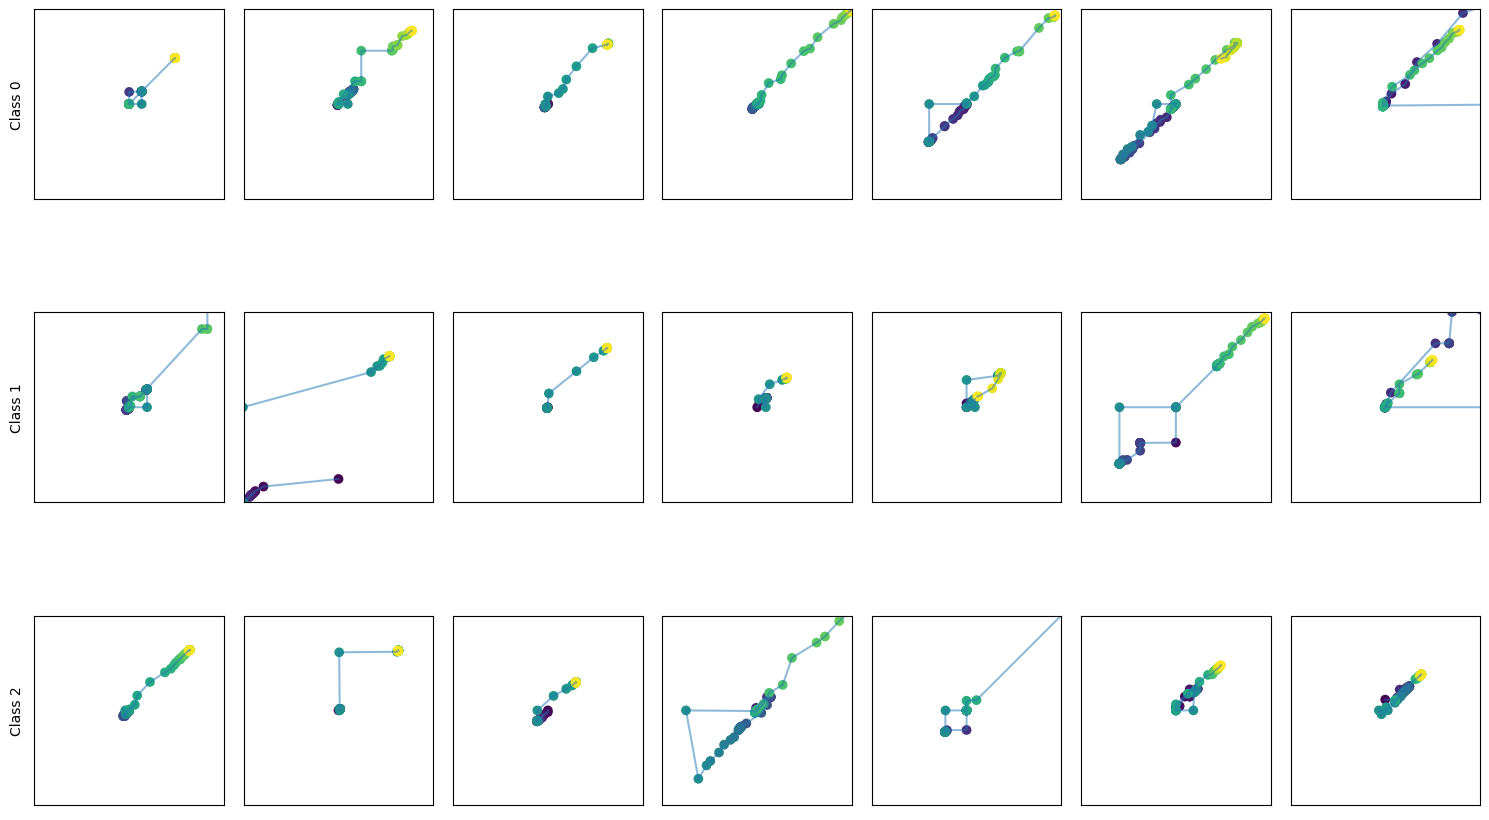

In [521]:
n_plot = 7
n_clust = n_clusters
plt.figure(figsize=(15, 10))

def plot_reaches_(x, y, duration=0):
    plt.plot(x, y, '-', alpha = 0.5)
    plt.scatter(x, y, c=np.arange(75))
    if duration != 0:
        plt.scatter(x[duration], y[duration], c = "r")
    plt.xlim(-0.05, 0.05)
    plt.ylim(-0.05, 0.05)

n = 0
for k in range(n_clust):
    k_data = dataset[k_mean_mask][Y_TSNE == k]
    for i in range(n_plot):
        idx = torch.randint(len(k_data), size=())
        k_data_ex = k_data[idx]
        plt.subplot(n_clust, n_plot, n + 1)
        plot_reaches_(k_data_ex[:, 0], k_data_ex[:, 1])
        if i == 0:
            plt.ylabel(f'Class {k}')
        n += 1
        plt.gca().set_aspect('equal')
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()

plt.show()

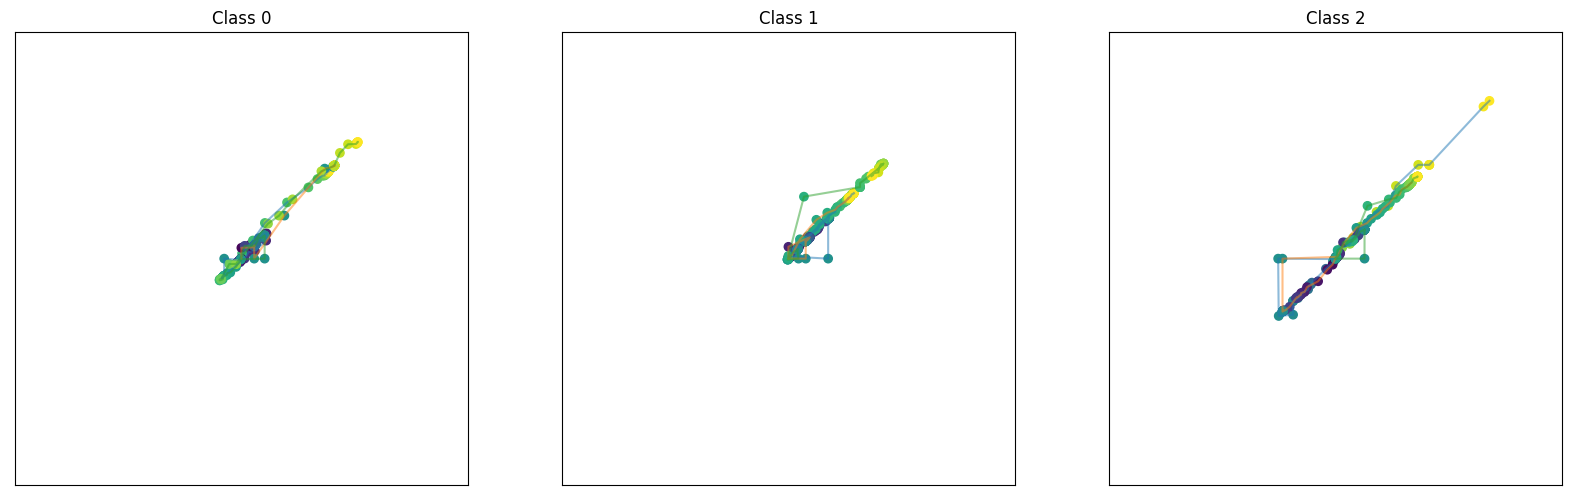

In [522]:
n_plot = 3
n_clust = n_clusters
plt.figure(figsize=(20, 6))

def plot_reaches_(x, y, duration=0):
    plt.plot(x, y, '-', alpha = 0.5)
    plt.scatter(x, y, c=np.arange(75))
    if duration != 0:
        plt.scatter(x[duration], y[duration], c = "r")
    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.1, 0.1)

for k in range(n_clust):
    k_data = dataset[k_mean_mask][Y_TSNE == k]
    plt.subplot(1, n_clust, k + 1)
    for i in range(n_plot):
        idx = torch.randint(len(k_data), size=())
        k_data_ex = k_data[idx]
        
        plot_reaches_(k_data_ex[:, 0], k_data_ex[:, 1])
        if i == 0:
            plt.title(f'Class {k}')
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
plt.show()

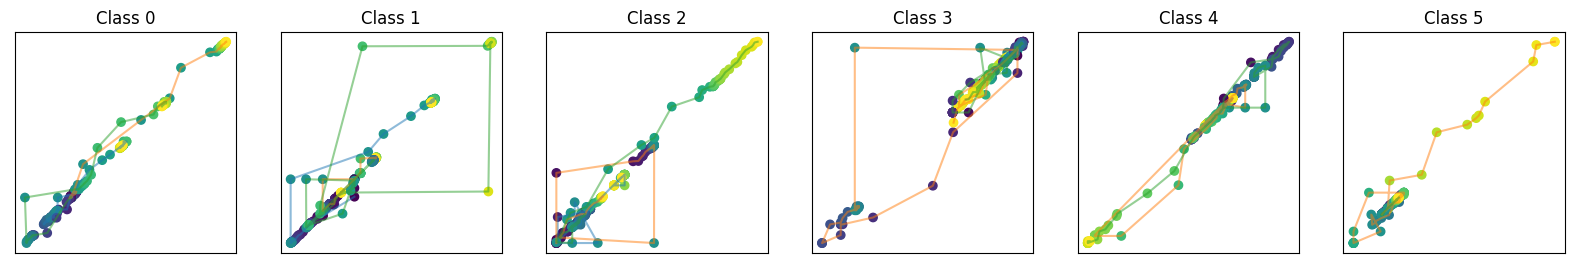

In [433]:
n_plot = 3
n_clust = n_clusters
plt.figure(figsize=(20, 6))

def plot_reaches_(x, y, duration=0):
    plt.plot(x, y, '-', alpha = 0.5)
    plt.scatter(x, y, c=np.arange(75))
    if duration != 0:
        plt.scatter(x[duration], y[duration], c = "r")
    # plt.xlim(-0.1, 0.1)
    # plt.ylim(-0.1, 0.1)

for k in range(n_clust):
    k_data = dataset[k_mean_mask][Y_TSNE == k]
    plt.subplot(1, n_clust, k + 1)
    for i in range(n_plot):
        idx = torch.randint(len(k_data), size=())
        k_data_ex = k_data[idx]
        
        plot_reaches_(k_data_ex[:, 0], k_data_ex[:, 1])
        if i == 0:
            plt.title(f'Class {k}')
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
plt.show()

### PCA

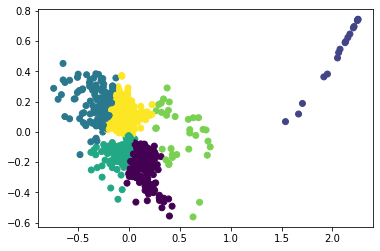

In [279]:
kmeans = KMeans(n_clusters=6)
Y_PCA = kmeans.fit_predict(X_PCA)
plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c = Y_PCA)

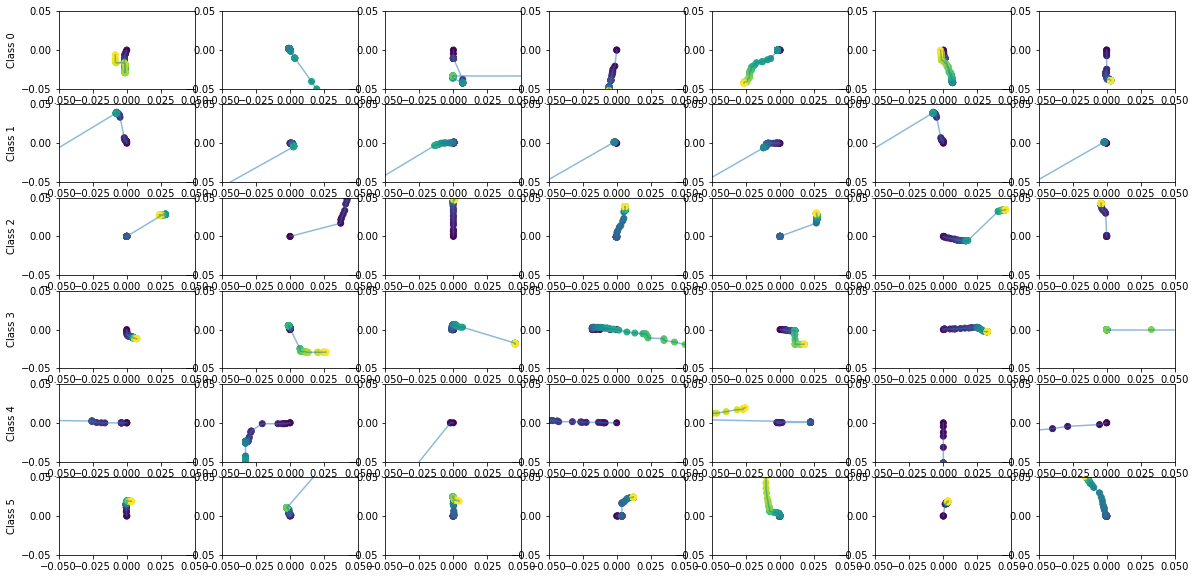

In [280]:
n_plot = 7
n_clust = 6
plt.figure(figsize=(20, 10))

def plot_reaches_(x, y, duration=0):
    plt.plot(x, y, '-', alpha = 0.5)
    plt.scatter(x, y, c=np.arange(75))
    if duration != 0:
        plt.scatter(x[duration], y[duration], c = "r")
    plt.xlim(-0.05, 0.05)
    plt.ylim(-0.05, 0.05)

n = 0
for k in range(n_clust):
    k_data = X_train.to('cpu')[Y_PCA == k]
    for i in range(n_plot):
        idx = torch.randint(len(k_data), size=())
        k_data_ex = k_data[idx]
        plt.subplot(n_clust, n_plot, n + 1)
        plot_reaches_(k_data_ex[0, :], k_data_ex[1, :])
        if i == 0:
            plt.ylabel(f'Class {k}')
        n += 1
plt.show()

## Custom loss 

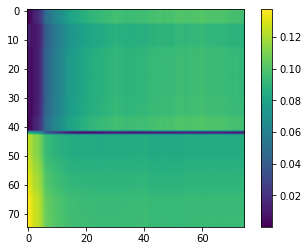

In [169]:
plt.imshow(torch.cdist(data_.double(), rae_recon.T.double()))
plt.colorbar()

In [49]:
rae_recon.T.shape

torch.Size([75, 2])

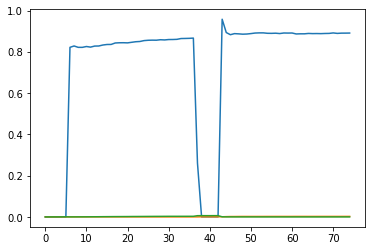

In [187]:
for (d1, d2) in zip(data_.unsqueeze(0), rae_recon.T.unsqueeze(0)):
    cs = torch.nn.functional.cosine_similarity(d1, d2)
l2 = torch.nn.functional.mse_loss(data_, rae_recon.T, reduction='none')
dist = torch.norm(data_ - rae_recon.T)
# plt.axhline(y=dist, color='r', linestyle='-')
# plt.axhline(y=torch.nn.functional.mse_loss(data_, rae_recon.T, reduction='sum'), color='g', linestyle='-')
# plt.axhline(y=torch.nn.functional.l1_loss(data_, rae_recon.T, reduction='sum'), color='yellow', linestyle='-')
plt.plot(cs)
plt.plot(l2)

In [193]:
torch.nn.functional.l1_loss(data_, rae_recon.T, reduction='none').max()

tensor(0.0783, dtype=torch.float64)

In [203]:
torch.nn.functional.l1_loss(data_, rae_recon.T, reduction='none').max(dim=0)

torch.return_types.max(
values=tensor([0.0507, 0.0783], dtype=torch.float64),
indices=tensor([74, 42]))

In [200]:
torch.nn.functional.l1_loss(data_, rae_recon.T, reduction='mean')

tensor(0.0250, dtype=torch.float64)

In [196]:
torch.nn.functional.l1_loss?

Signature:
torch.nn.functional.l1_loss(
    input: torch.Tensor,
    target: torch.Tensor,
    size_average: Union[bool, NoneType] = None,
    reduce: Union[bool, NoneType] = None,
    reduction: str = 'mean',
) -> torch.Tensor
Docstring:
l1_loss(input, target, size_average=None, reduce=None, reduction='mean') -> Tensor

Function that takes the mean element-wise absolute value difference.

See :class:`~torch.nn.L1Loss` for details.
File:      /opt/anaconda3/envs/Neuromatch_2022_EcoG_movements/lib/python3.8/site-packages/torch/nn/functional.py
Type:      function


In [116]:
1 - cs.mean()

tensor(0.1387, dtype=torch.float64)

In [66]:
data_.unsqueeze(0).shape

torch.Size([1, 75, 2])

In [76]:
for (d1, d2) in zip(data_.unsqueeze(0), rae_recon.T.unsqueeze(0)):
    cs = torch.nn.functional.cosine_similarity(d1, d2).max()
    print(cs)

tensor(0.9990, dtype=torch.float64)


In [78]:
for (d1, d2) in zip(data_.unsqueeze(0), rae_recon.T.unsqueeze(0)):
    cs = torch.nn.functional.cosine_similarity(d1, d1).mean()
    print(cs)

tensor(0.9867, dtype=torch.float64)


In [83]:
torch.nn.functional.cosine_similarity(data_, -data_)

tensor([ 0.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000], dtype=torch.float64)

In [80]:
data_.shape

torch.Size([75, 2])

In [130]:
# SEE: https://stackoverflow.com/questions/66139651/which-loss-function-calculates-the-distance-between-two-contours
def contour_divergence(c1, c2, func = lambda x: x**2):
    c1 = torch.atleast_3d(c1);
    c2 = torch.atleast_3d(c2);
    f = func(torch.amin(torch.cdist(c1, c2), dim=2));
    # this computes the length of each segment connecting two consecutive points
    df = torch.sum((c1[:, 1:, :] - c1[:, :-1, :])**2, axis=2)**0.5;
    # here is the trapesoid rule
    return torch.sum((f[:, :-1] + f[:, 1:]) * df[:, :], axis=1) / 4.0;

def contour_dist(c1, c2, func = lambda x: x**2):
    return contour_divergence(c1, c2, func) + contour_divergence(c2, c1, func)


In [133]:
contour_dist(data_.double(), rae_recon.T.double()).shape

torch.Size([75])

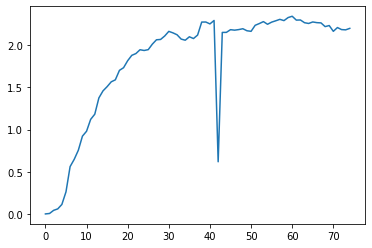

In [171]:
for (d1, d2) in zip(data_.unsqueeze(0), rae_recon.T.unsqueeze(0)):
    cs = torch.nn.functional.cosine_similarity(d1, d2)
l2 = torch.nn.functional.mse_loss(data_, rae_recon.T, reduction='none')
cd = contour_dist(data_.double(), rae_recon.T.double(), lambda x: x * 1000)
# plt.plot(cs)
plt.plot(cd)
# plt.plot(l2)

tensor(0., dtype=torch.float64)

## Linear AE

In [182]:
lae_test = LinearAutoencoder(75 * 2, 16)
summary(lae_test, (1, 75 * 2),
        col_names=["input_size", "output_size", "num_params",]) 

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LinearAutoencoder                        [1, 150]                  [1, 150]                  --
├─Sequential: 1-1                        [1, 150]                  [1, 16]                   --
│    └─Linear: 2-1                       [1, 150]                  [1, 128]                  19,328
│    └─ReLU: 2-2                         [1, 128]                  [1, 128]                  --
│    └─Linear: 2-3                       [1, 128]                  [1, 64]                   8,256
│    └─ReLU: 2-4                         [1, 64]                   [1, 64]                   --
│    └─Linear: 2-5                       [1, 64]                   [1, 16]                   1,040
├─Sequential: 1-2                        [1, 16]                   [1, 150]                  --
│    └─Linear: 2-6                       [1, 16]                   [1, 64]                   1,088
│    └─ReLU: 2-7      

In [ ]:
i = 11
one_sample_data = X_train[i:i+1, :, :]
plot_reaches_(one_sample_data[0, :, 0].to('cpu').squeeze(), one_sample_data[0, :, 1].to('cpu').squeeze())

In [219]:
pl.seed_everything(42)
_, n_times, n_features = X_train.shape
n_embedding = 50

# Initialize model and Trainer
lae = LinearAutoencoder(75 * 2, n_embedding)
lae.lr = 1e-3

pl.utilities.model_summary.summarize(lae, max_depth=-1)

Global seed set to 42


   | Name        | Type       | Params
--------------------------------------------
0  | encoder     | Sequential | 150 K 
1  | encoder.0   | Linear     | 60.4 K
2  | encoder.1   | ReLU       | 0     
3  | encoder.2   | Linear     | 80.2 K
4  | encoder.3   | ReLU       | 0     
5  | encoder.4   | Linear     | 10.1 K
6  | decoder     | Sequential | 150 K 
7  | decoder.0   | Linear     | 10.2 K
8  | decoder.1   | ReLU       | 0     
9  | decoder.2   | Linear     | 80.4 K
10 | decoder.3   | ReLU       | 0     
11 | decoder.4   | Linear     | 60.1 K
12 | decoder.5   | Tanh       | 0     
13 | custom_loss | MSELoss    | 0     
--------------------------------------------
301 K     Trainable params
0         Non-trainable params
301 K     Total params
1.206     Total estimated model params size (MB)

In [220]:
n_epochs = 50
batch_size = 20

logger = TensorBoardLogger(
    "tb_logs",
    name=f"LAE_lr_{lae.lr}_bs_{batch_size}_n_emb_{n_embedding}_grad_acc_F_LR_sch_T")


trainer = pl.Trainer(
    max_epochs=n_epochs,
    accelerator='mps', 
    logger=logger,
    # accumulate_grad_batches={0: 8, 4: 4, 8: 1}
    )

# Perform training
trainer.fit(lae,
            DataLoader(
                torch.swapaxes(X_train, 2, 1).view(X_train.size(0), -1), # torch.swapaxes(one_sample_data, 2, 1).view(one_sample_data.size(0), -1),  
                batch_size=batch_size,
                shuffle=True),
            DataLoader(
                torch.swapaxes(X_val, 2, 1).view(X_val.size(0), -1), # torch.swapaxes(one_sample_data, 2, 1).view(one_sample_data.size(0), -1),  
                batch_size=batch_size,
                shuffle=False),
            )

# Perform evaluation
trainer.test(lae, DataLoader(
    torch.swapaxes(X_test, 2, 1).view(X_test.size(0), -1), # torch.swapaxes(one_sample_data, 2, 1).view(one_sample_data.size(0), -1), 
    shuffle=False))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type       | Params
-------------------------------------------
0 | encoder     | Sequential | 150 K 
1 | decoder     | Sequential | 150 K 
2 | custom_loss | MSELoss    | 0     
-------------------------------------------
301 K     Trainable params
0         Non-trainable params
301 K     Total params
1.206     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0010670407209545374
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0010670407209545374}]

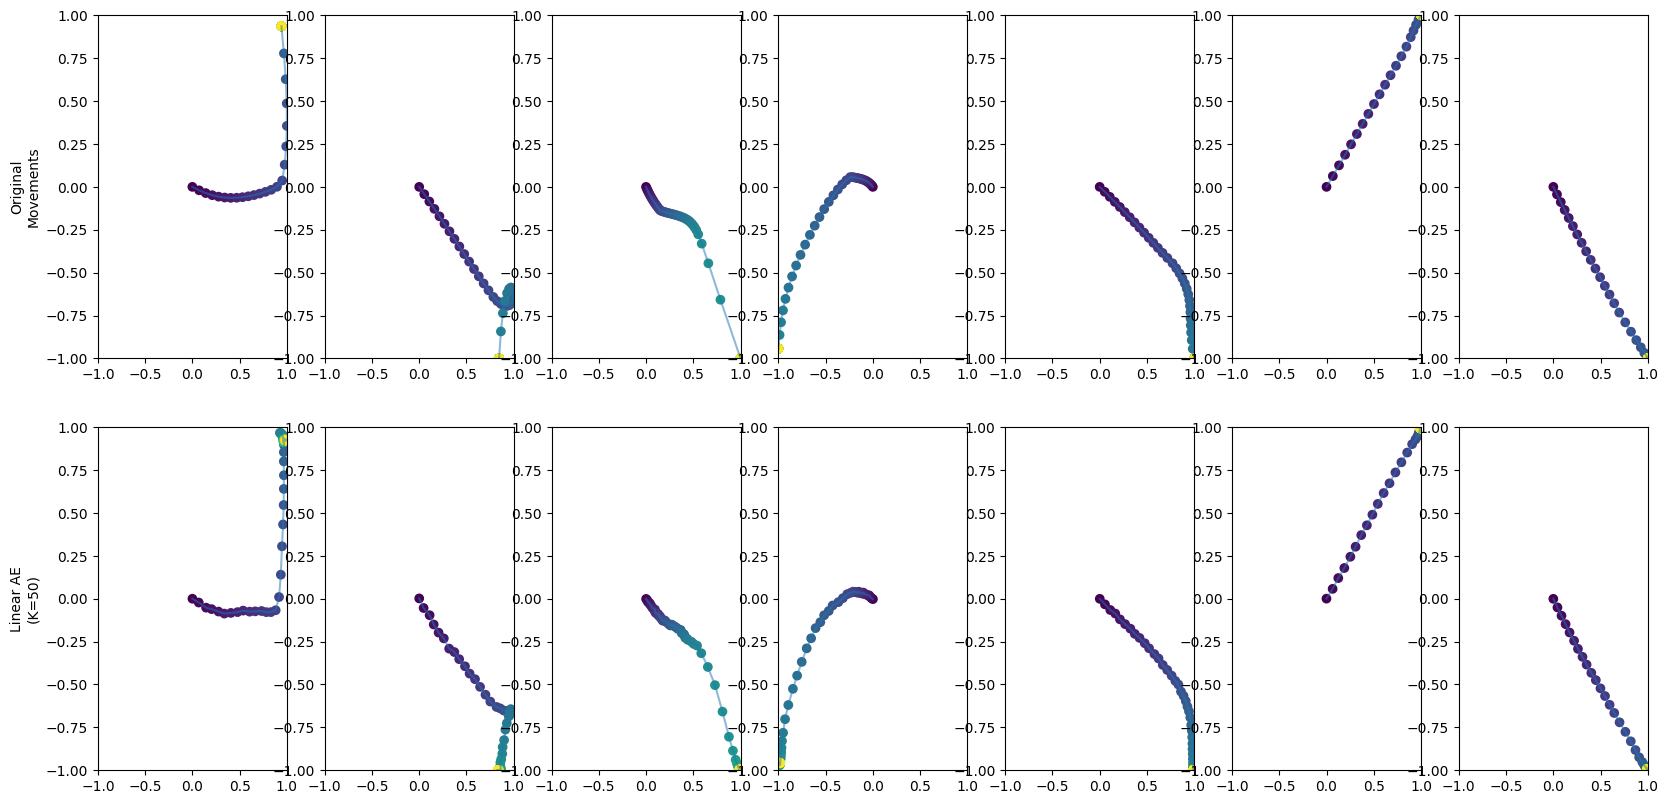

In [221]:
n_plot = 7
plt.figure(figsize=(20, 10))
dataset_all = X_train.to('cpu')
# dataset_all = torch.tensor(dataset[k_mean_labels == 8], device='cpu') # [k_mean_labels == 8]
# dataset_all = one_sample_data.to('cpu')
# dataset_all = torch.tensor(dataset[k_mean_mask], device='cpu')

def plot_reaches_(x, y):
    # x = np.sqrt(np.abs(x)) * np.sign(x)
    # y = np.sqrt(np.abs(y)) * np.sign(y)
    plt.plot(x, y, '-', alpha = 0.5)
    plt.scatter(x, y, c=np.arange(75))
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

for i in range(n_plot):
    idx = torch.randint(len(dataset_all), size=())
    data_ = dataset_all[idx]
    with torch.no_grad():
      # Get reconstructed movements from autoencoder
      lae_recon = lae(torch.swapaxes(data_.unsqueeze(0), 2, 1).view(1, -1).to('cpu').float())[0]

    plt.subplot(2, n_plot, i+1)
    plot_reaches_(data_[:, 0], data_[:, 1])
    if i == 0:
        plt.ylabel('Original\nMovements') # (scaled)


    plt.subplot(2, n_plot, i + 1 + n_plot)
    plot_reaches_(lae_recon.reshape((2, 75))[0, :], lae_recon.reshape((2, 75))[1, :])
    if i == 0:
        plt.ylabel(f'Linear AE\n(K={n_embedding})')

plt.show()

In [222]:
from sklearn.manifold import TSNE

In [223]:
with torch.no_grad():
    all_data = torch.tensor(dataset[:, :75, :], device='cpu', dtype=DTYPE)
    z_x_train = lae.encoder(torch.swapaxes(all_data, 2, 1).view(all_data.size(0), -1))
    z_x_train = z_x_train.detach().numpy()

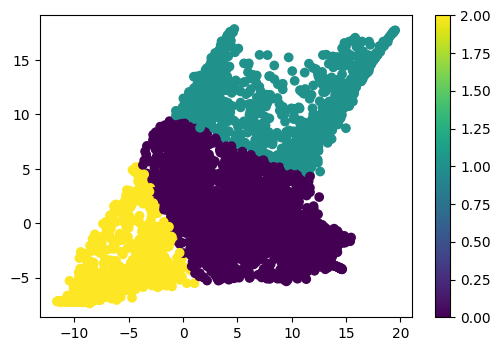

In [210]:
# n_clusters = 3
# kmeans = KMeans(n_clusters=n_clusters)
# label = kmeans.fit_predict(z_x_train)
# plt.scatter(z_x_train[:, 0], z_x_train[:, 1], c = label)
# plt.colorbar()

In [ ]:
X_TSNE = TSNE(n_components=2, random_state=SEED).fit_transform(z_x_train)

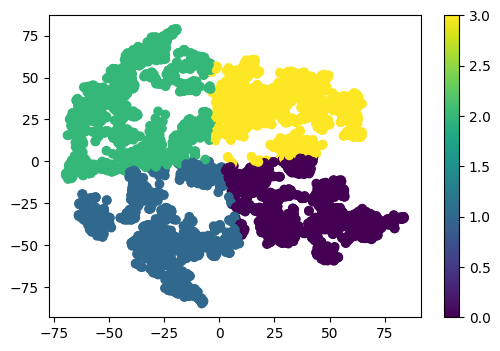

In [227]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters)
Y_TSNE = kmeans.fit_predict(X_TSNE)
plt.scatter(X_TSNE[:, 0], X_TSNE[:, 1], c = Y_TSNE)
plt.colorbar()

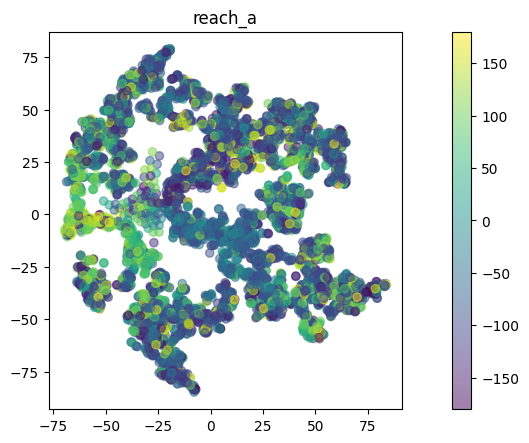

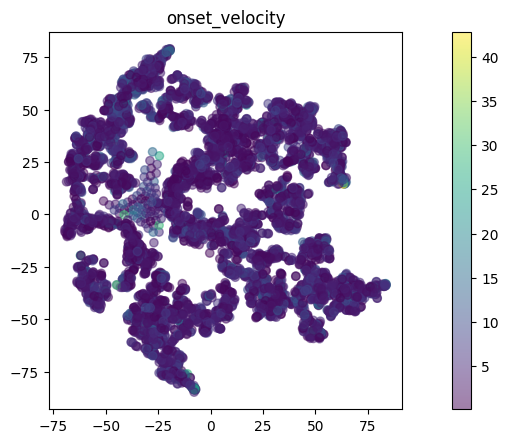

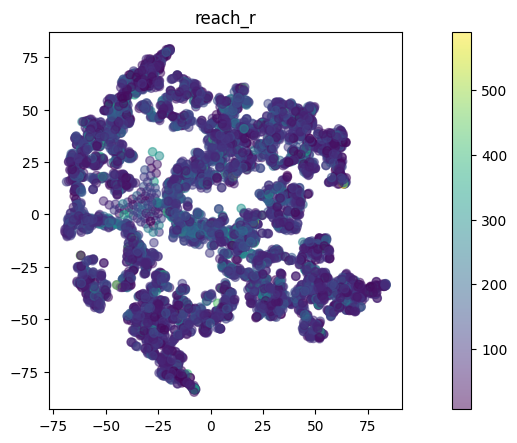

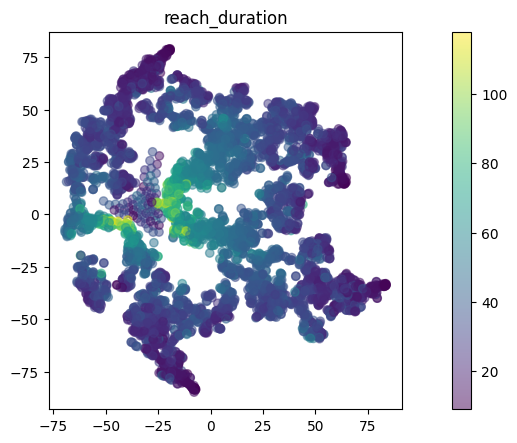

In [235]:
for par in ['reach_a', 'onset_velocity', 'reach_r', 'reach_duration']:
    plt.figure(figsize=(13, 5))
    plt.scatter(X_TSNE[:, 0], X_TSNE[:, 1], c = data.loc[:, par].values, alpha = 0.5)
    plt.title(par)
    plt.colorbar()
    plt.gca().set_aspect('equal')
    plt.show()

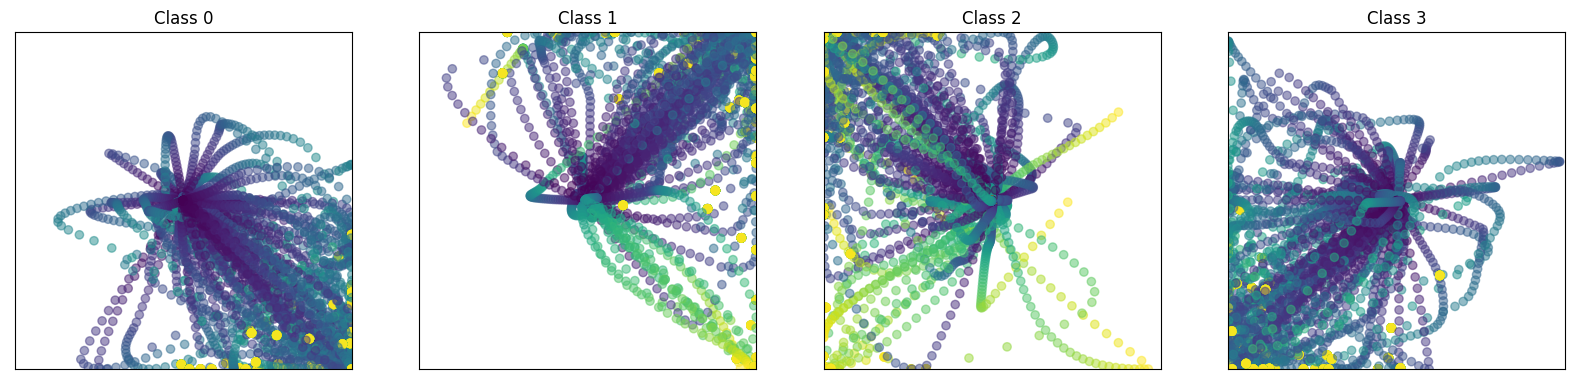

In [249]:
n_plot = 110
n_clust = 4
plt.figure(figsize=(20, 6))

def plot_reaches_(x, y):
    # plt.plot(x, y, '-', alpha = 0.5)
    plt.scatter(x, y, c=np.arange(75), alpha = 0.5)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    

for k in range(n_clust):
    k_data = dataset[:, :75, :][Y_TSNE == k]
    plt.subplot(1, n_clust, k + 1)
    for i in range(n_plot):
        idx = torch.randint(len(k_data), size=())
        k_data_ex = k_data[idx]
        
        plot_reaches_(k_data_ex[:, 0], k_data_ex[:, 1])
        if i == 0:
            plt.title(f'Class {k}')
    plt.gca().set_aspect('equal')
    plt.xticks([])
    
    plt.yticks([])
plt.show()

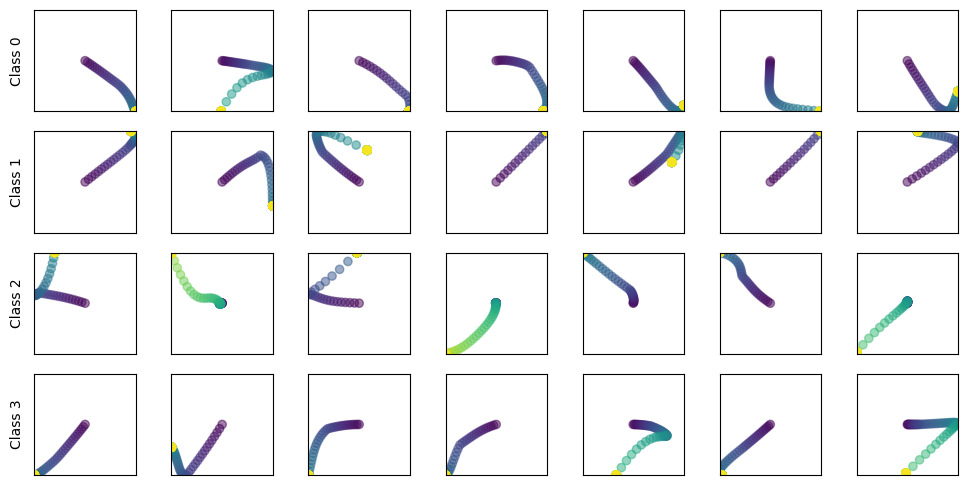

In [252]:
n_plot = 7
n_clust = n_clusters
plt.figure(figsize=(10, 5))

def plot_reaches_(x, y):
    # plt.plot(x, y, '-', alpha = 0.5)
    plt.scatter(x, y, c=np.arange(75), alpha = 0.5)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

n = 0
for k in range(n_clust):
    k_data = dataset[:, :75, :][Y_TSNE == k]
    for i in range(n_plot):
        idx = torch.randint(len(k_data), size=())
        k_data_ex = k_data[idx]
        plt.subplot(n_clust, n_plot, n + 1)
        plot_reaches_(k_data_ex[:, 0], k_data_ex[:, 1])
        if i == 0:
            plt.ylabel(f'Class {k}')
        n += 1
        plt.gca().set_aspect('equal')
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()

plt.show()

In [236]:
from scipy import stats
stats.spearmanr([1,2,3,4,5], [5,6,7,8,7])

SpearmanrResult(correlation=0.8207826816681233, pvalue=0.08858700531354381)

In [239]:
stats.spearmanr(data.loc[:, 'reach_a'].values, Y_TSNE)

SpearmanrResult(correlation=-0.049822110535186245, pvalue=0.00011542520829750965)